# Part 1c: Scraping the Web with Python

[Web scraping](https://en.wikipedia.org/wiki/Web_scraping) is a technique to automatically extract data from websites. It works by gathering and copying data from the web into a central local database. 

This process is typically carried out using a tool called a "scraper". First, it sends a `GET` query to a specific website. Then, it parses an HTML document based on the retrieved result. After it’s done, the scraper searches for the data you need within the document and converts it into the specified format.

In Python, the two most commonly used scraping packages are [Beautiful Soup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/) and [Scrapy](https://scrapy.org/). In this tutorial, we'll use Beautiful Soup to search for apartments rentals from Craigslist's Toronto [housing section](https://toronto.craigslist.org/search/apa?). 

We'll first need to install it which can be done with this command: 

```
pip install beautifulsoup4
```

We'll also need to install [requests](https://2.python-requests.org/en/master/) which will let us make HTTP requests. With `requests`, we can easily pull HTML code from a website. To learn more about this useful package, check out this [article](https://realpython.com/python-requests/).

```
pip install requests
```

Now let's import these packages into our working Python environment:

In [1]:
import requests 
from bs4 import BeautifulSoup

The first thing we need to do is get the raw HTML from Craigslist's Toronto food services page:

<img src="assets/imgs/craigslist_listings.png" width="50%"/>

We'll use `requests` to do this:

In [2]:
craigslist_url = "https://toronto.craigslist.org/search/apa"

page = requests.get(craigslist_url)

page

<Response [200]>

We get the status code `200` which means that our HTTP request was successful! If the code was 404, that would suggest the page was not found. We can access the HTML content of the page using `page.content`. It's a very large body of HTML, so let's look at the first 500 characters of the response:

In [3]:
print(page.content[0:500])

b'\xef\xbb\xbf<!DOCTYPE html>\n<html class="no-js"><head>\n    <title>toronto apts/housing for rent  - craigslist</title>\n\n    <meta name="description" content="toronto apts/housing for rent  - craigslist">\n    <meta http-equiv="X-UA-Compatible" content="IE=Edge"/>\n    <link rel="canonical" href="https://toronto.craigslist.org/search/apa">\n    <link rel="alternate" type="application/rss+xml" href="https://toronto.craigslist.org/search/apa?format=rss" title="RSS feed for craigslist | toronto apts/housing for '


The next thing we'll do is represent Craigslist's raw HTML as a BeautifulSoup object, which parses the HTML and allows us to search through the content in an efficient way. 

In [4]:
page_content = BeautifulSoup(page.content, "html.parser")

We need to find out which parts of the HTML represent the apartment listings that we're looking for. If we're using Chrome as our web browser, we can use DevTools:

<img src="assets/imgs/html_devtools.png" width="70%">

Firefox and Internet Explorer have their own versions of HTML page inspectors. 

If you look closely at the HTML, you'll see that each apartment listing is represented inside a `<li>` element.

<img src="assets/imgs/html_li_element.png" width="60%"/>

We can access all `<li>`'s of the page using BeautifulSoup's [find_all()](https://www.crummy.com/software/BeautifulSoup/bs4/doc/#find) method.

In [5]:
li_elements = page_content.find_all("li", class_="result-row")

print(f"There are {len(li_elements)} li elements on the page.")

There are 120 li elements on the page.


There are 120 listings on this webpage. Let's look at the first one.

In [6]:
one_apartment_listing = li_elements[0]

one_apartment_listing

<li class="result-row" data-pid="7050771974">
<a class="result-image gallery" data-ids="1:00t0t_aKTCHwhcXpl,1:01717_eXBQsOuBIuN,1:00x0x_1h8QkC248sV,1:00c0c_3T2XrNG7pTf,1:00D0D_f0QhnLI5tRY,1:00q0q_ZmmQscLBr2" href="https://toronto.craigslist.org/tor/apa/d/downtown-toronto-1-bedroom-for-rent-at/7050771974.html">
<span class="result-price">$2300</span>
</a>
<p class="result-info">
<span class="icon icon-star" role="button">
<span class="screen-reader-text">favorite this post</span>
</span>
<time class="result-date" datetime="2020-01-09 15:14" title="Thu 09 Jan 03:14:58 PM">Jan  9</time>
<a class="result-title hdrlnk" data-id="7050771974" href="https://toronto.craigslist.org/tor/apa/d/downtown-toronto-1-bedroom-for-rent-at/7050771974.html">1 Bedroom for Rent at Bay &amp; Harbour Street</a>
<span class="result-meta">
<span class="result-price">$2300</span>
<span class="housing">
                    1br -
                    499ft<sup>2</sup> -
                </span>
<span class="result-hoo

The HTML above represents one apartment listing. We can get information from this listing such as:

- price: `<span class="result-price">`
- number of bedrooms: `<span class="housing">`
- time at which listing was posted: `<time class="result-date">`

In this tutorial, we want to get the price and number of bedrooms from each listing. This means we should be focusing on the HTML elements containing `result-price` and `housing`. 

Let's first get the price.

In [7]:
price = one_apartment_listing.find('span', class_='result-price')
price

<span class="result-price">$2300</span>

Applying `find()` to `result-price` will return the HTML containing this class name. We only want the text inside this HTML, so we'll apply `.text` to our price object. 

In [8]:
price.text

'$2300'

Great! Now let's proceed to the number of bedrooms. This is inside the HTML span element that contains the `"housing"` class. 

In [9]:
n_bedrooms = one_apartment_listing.find('span', class_='housing')
n_bedrooms.text

'\n                    1br -\n                    499ft2 -\n                '

This text needs to be cleaned up. We should remove the white space using the [strip()](https://www.programiz.com/python-programming/methods/string/strip) method. We will also remove the "br" (short for bedrooms) to get just the number. We can use a cool trick where we split the text with `br` and take the first element of the resulting list.

In [10]:
n_bedrooms_text = n_bedrooms.text.strip()
n_bedrooms_text.split('br')[0]

'1'

We now know how to get price information and number of bedrooms from a single apartment listing. Let's loop over all listing and create two lists - one containing prices, and another containing number of bedrooms.

In some listings, the `<span class="housing">` element doesn't exist. So if we tried to apply `n_bedrooms.text` when `n_bedrooms` is `None`, it would fail. To avoid this error, we'll set `n_bedrooms` to -999 to represent that it's a missing value. Check out the implementation in the code below.

In [11]:
all_prices = []
all_n_bedrooms = []

for listing  in li_elements:
    # get price info
    price = listing.find('span', class_='result-price')
    price = price.text.replace('$', '')
    all_prices.append(int(price))
    
    # get number of bedroom info
    n_bedrooms = listing.find('span', class_='housing')
    if n_bedrooms and 'br' in n_bedrooms.text:
        n_bedrooms_text = n_bedrooms.text.strip().split('br')[0]
    else: 
        n_bedrooms_text = -999
    all_n_bedrooms.append(int(n_bedrooms_text))

We have two lists containing information about aparmtnet rentals on Craigslist. Let's see what they look like. 

In [23]:
print("Apartment prices:", all_prices)

Apartment prices: [2300, 2400, 2700, 2950, 2600, 825, 1990, 1150, 2400, 1899, 1299, 1700, 1600, 2550, 1600, 500, 1700, 2300, 2600, 4250, 3495, 5995, 4995, 2300, 2100, 3695, 4795, 13995, 7995, 4995, 24995, 8495, 2995, 2795, 19995, 4595, 4195, 2995, 3495, 3495, 1750, 2895, 4495, 2050, 2599, 2695, 4250, 6995, 5995, 2695, 4995, 3995, 2695, 2195, 2695, 3995, 7995, 2595, 7495, 3300, 3495, 2495, 3350, 2695, 5195, 5995, 7260, 5595, 4995, 7450, 2395, 3495, 3795, 2895, 3495, 2495, 3095, 3495, 3295, 4995, 4695, 3195, 1950, 2995, 7995, 3495, 3150, 3650, 4995, 5495, 2395, 3545, 2995, 2095, 2495, 11995, 3795, 1625, 3295, 3995, 5795, 1350, 800, 3600, 2400, 800, 2200, 2200, 1600, 2500, 2300, 3500, 2345, 3700, 780, 790, 755, 3499, 1495, 3400]


In [22]:
print("Number of bedrooms:", all_n_bedrooms)

Number of bedrooms: [1, 1, 2, 2, 2, 1, 1, 1, -999, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 3, 1, 1, 1, 1, 3, 4, 2, 3, 2, 1, 2, 4, 3, 3, 2, 1, 3, 1, 1, 2, 2, 1, 1, 1, 5, 3, 1, 2, 2, 1, 1, 1, 1, 2, 1, 2, 1, 2, 1, -999, 3, 2, 3, 2, 2, 2, 3, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 4, 1, 1, 1, 2, 3, 1, 1, 1, 1, 1, 4, 2, 1, 1, 2, 2, 1, 1, 3, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, -999, -999, -999, 2, 1, 2]


As you can see in the list above, there are some listings that have number of bedrooms missing. These are represented by -999. 

Our next steps is to represent these two lists in the form of a pandas dataframe, which will give us a better visualization of the data we collected. We'll be covering pandas dataframes in Part 2 of the series, so don't worry about the syntax for now.

In [14]:
import pandas as pd

apartment_listings = pd.DataFrame({
    'price': all_prices,
    'n_bedrooms': all_n_bedrooms
})

print(f"Shape: {apartment_listings.shape}")
apartment_listings.head()

Shape: (120, 2)


,price,n_bedrooms
0,2300,1
1,2400,1
2,2700,2
3,2950,2
4,2600,2


In [15]:
apartment_listings = apartment_listings[apartment_listings['n_bedrooms']>=0]

apartment_listings.shape

(115, 2)

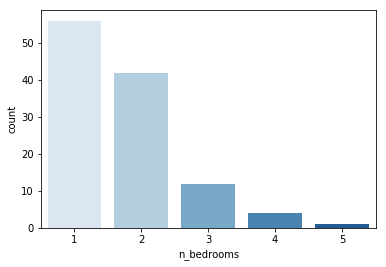

In [18]:
import seaborn as sns

sns.countplot(apartment_listings['n_bedrooms'], palette='Blues')

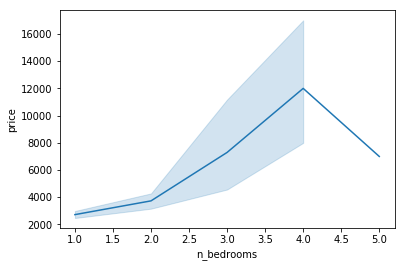

In [19]:
sns.lineplot(x='n_bedrooms', y='price', data=apartment_listings)

### Scraping Etiquette

Web scraping can also overload a server, if you are making a large amount of requests, and scraping large amounts of data.

### Next Steps

- **Pagination**
    - We implemented a scraper that only looks at the first page of Craigslist's housing section. Expand on this scraper by adding pagination. This [tutorial](https://blog.floydhub.com/web-scraping-with-python/) explains how to incorporate pagination into a Beautiful Soup scraper.
- **Nested pages**
    - We looked at the information provided on the overview page of Craigslist. If you click on an apartment listing link, it'll redirect to a page with more information about that apartment listing. Try implementing logic in your scraper that goes to each apartment rental page and gets more information from that listing (e.g., GPS coordinates).
- **Build another scraper from scratch**
    - Follow this [tutorial](https://realpython.com/beautiful-soup-web-scraper-python/) to build a job site scraper with Beautiful Soup

### Resources

- A Guide to Python's Requests Library - [link](https://realpython.com/python-requests/)
- Practical Introduction to Web Scraping in Python - [link](https://realpython.com/python-web-scraping-practical-introduction/)